In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import os

In [2]:
# What I want to do: 
# Create python code that is executable on the command line (split_VPs.py) and takes the following arguments: 
# sample_name
# r9_modkit (bedfile)
# r10_modkit (bedfile)
# graph_binning (file to bin intervals and graph by - either R9 or R10)
# binning_intervals (inervals to bin the data by - ex. tens (0, 10, 20, 30... 100) or twenties (0, 20, 40...100))
# cov_min (minimum coverage, default = 20)
# cov_max (maximum coverage, default = None)
# --help message explaining what these things are

In [3]:
sample = 'HG002'
select = {"chr1", "chr2", "chr3", "chr4",'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY', 'chrM'}

In [4]:
r9_modkit = "/Users/gennerrm/Desktop/modkit_files/HG002_R9.hg38.modkit.comb.bed"

In [5]:
#read in R9 modkit file and convert to df
print("Reading R9 data...")
with open(r9_modkit, 'r') as f_R9:
    R9 = pd.read_csv(f_R9, sep="\t", header=None, engine="c",
    usecols=["chrom", "start", "end", "coverage", "freq", "mod", "canon"],
    dtype={
        "chrom":str, "start":int, "end":int, "name":str, "score":int, "strand":str,
        "start2":int, "end2":int, "color":str,
        "coverage":int, "freq":float, "mod":int, "canon":int, "other_mod":int, 'delete':int, 'fail':int, 'diff':int, 'no_call':int},
    names=[
        "chrom", "start", "end", "name", "score", "strand",
        "start2", "end2", "color",
        "coverage", "freq", "mod", "canon", "other_mod", "delete", "fail", 'diff', 'no_call'])

R9

Reading R9 data...


,chrom,start,end,coverage,freq,mod,canon
0,chr1,10468,10469,118,87.29,103,15
1,chr1,10470,10471,112,89.29,100,12
2,chr1,10483,10484,112,91.96,103,9
3,chr1,10488,10489,129,96.12,124,5
4,chr1,10492,10493,122,91.80,112,10
...,...,...,...,...,...,...,...
28941572,chrEBV,171755,171756,150,14.00,21,129
28941573,chrEBV,171765,171766,208,12.50,26,182
28941574,chrEBV,171780,171781,41,24.39,10,31
28941575,chrEBV,171797,171798,22,22.73,5,17


In [6]:
#filter for  chromosomes 1-22,X,Y,M and coverage > 20 and < 200

R9 = R9.loc[
    (R9['chrom'].isin(select)) &
    (R9['coverage'] > 20) &
    (R9['coverage'] < 200)]

R9

,chrom,start,end,coverage,freq,mod,canon
0,chr1,10468,10469,118,87.29,103,15
1,chr1,10470,10471,112,89.29,100,12
2,chr1,10483,10484,112,91.96,103,9
3,chr1,10488,10489,129,96.12,124,5
4,chr1,10492,10493,122,91.80,112,10
...,...,...,...,...,...,...,...
28797589,chrY,56887220,56887221,50,98.00,49,1
28797590,chrY,56887399,56887400,45,93.33,42,3
28797591,chrY,56887579,56887580,43,97.67,42,1
28797592,chrY,56887700,56887701,42,23.81,10,32


In [7]:
print("Reading R10 data...")
R10 = pd.read_csv(
    "/Users/gennerrm/Desktop/modkit_files/HG002_R10.hg38.modkit.comb.bed",
    sep="\t", header=None, engine="c",
    usecols=["chrom", "start", "end", "coverage", "freq", "mod", "canon"],
    dtype={
        "chrom":str, "start":int, "end":int, "name":str, "score":int, "strand":str,
        "start2":int, "end2":int, "color":str,
        "coverage":int, "freq":float, "mod":int, "canon":int, "other_mod":int, 'delete':int, 'fail':int, 'diff':int, 'no_call':int},
    names=[
        "chrom", "start", "end", "name", "score", "strand",
        "start2", "end2", "color",
        "coverage", "freq", "mod", "canon", "other_mod", "delete", "fail", 'diff', 'no_call'])

#filter for coverage > 20 and < 200
R10 = R10.loc[
    (R10['chrom'].isin(select)) &
    (R10['coverage'] > 20) &
    (R10['coverage'] < 200)]

R10

Reading R10 data...


,chrom,start,end,coverage,freq,mod,canon
0,chr1,10468,10469,80,97.50,78,2
1,chr1,10470,10471,82,95.12,78,4
2,chr1,10483,10484,92,95.65,88,4
3,chr1,10488,10489,98,100.00,98,0
4,chr1,10492,10493,111,99.10,110,1
...,...,...,...,...,...,...,...
28759848,chrY,56887098,56887099,89,94.38,84,5
28759849,chrY,56887220,56887221,68,100.00,68,0
28759850,chrY,56887399,56887400,68,98.53,67,1
28759851,chrY,56887579,56887580,66,100.00,66,0


In [8]:
# inner merge to get dataframe with CpG sites that are shared between R9 and R10
inner = pd.merge(R9, R10, how="inner", on=["chrom", "start", "end"], suffixes=[".R9", ".R10"])
inner

,chrom,start,end,coverage.R9,freq.R9,mod.R9,canon.R9,coverage.R10,freq.R10,mod.R10,canon.R10
0,chr1,10468,10469,118,87.29,103,15,80,97.50,78,2
1,chr1,10470,10471,112,89.29,100,12,82,95.12,78,4
2,chr1,10483,10484,112,91.96,103,9,92,95.65,88,4
3,chr1,10488,10489,129,96.12,124,5,98,100.00,98,0
4,chr1,10492,10493,122,91.80,112,10,111,99.10,110,1
...,...,...,...,...,...,...,...,...,...,...,...
25042706,chrY,56887098,56887099,58,87.93,51,7,89,94.38,84,5
25042707,chrY,56887220,56887221,50,98.00,49,1,68,100.00,68,0
25042708,chrY,56887399,56887400,45,93.33,42,3,68,98.53,67,1
25042709,chrY,56887579,56887580,43,97.67,42,1,66,100.00,66,0


In [9]:
# Create list (bins) of integers within given increment and range, ex. bins_10 is increments of 10 from 0-100
 
bins_10 = 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100
bins_20 = 0, 20, 40, 60, 80, 100

# tried to make a function for this and it didn't work?
#def binning(inc):
#    return list(range(0, 101, inc))     
# Driver Code
#inc = 10
#bins = print(binning(10))

In [10]:
#make subset dataframe with R9 and R10 frequency columns 
freqs = inner[['freq.R9', 'freq.R10']]

# this adds a column that rounds up each R9 methylation frequency to the tenths place - ex. 87.3.5 -> 90.0, and assigns the corresponding R10 value to that same interval regardless of its value
# This is binning the intervals according to R9. Could also bin by R10 by switching it to pd.cut(freqs['freq.R10'])

freqs['ints'] = pd.cut(freqs['freq.R9'], bins=bins_10)

#convert df from int to str
freqs = freqs.astype({'ints':'string'})

#delete the start value of the interval so it's just one number - so (90.0, 100.0] becomes 100 - and then convert back to float 
freqs['ints'] = freqs['ints'].str[1:-1]
freqs[['int_start', 'int_end']] = freqs.ints.str.split(',', expand=True)
freqs['int_end'] = freqs['int_end'].astype(float)

#grab only these columns 
freqs = freqs[['freq.R9', 'freq.R10', 'int_end']]

freqs

/var/folders/j1/3pvq78vd5lvcvg4f6v4ct63w44fvfw/T/ipykernel_3580/945713376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqs['ints'] = pd.cut(freqs['freq.R9'], bins=bins_10)


,freq.R9,freq.R10,int_end
0,87.29,97.50,90.0
1,89.29,95.12,90.0
2,91.96,95.65,100.0
3,96.12,100.00,100.0
4,91.80,99.10,100.0
...,...,...,...
25042706,87.93,94.38,90.0
25042707,98.00,100.00,100.0
25042708,93.33,98.53,100.0
25042709,97.67,100.00,100.0


In [11]:
# add two columns with R9 and R10 for when I separate them out later 
freqs.insert(1, 'R9', 'R9')
freqs.insert(2, 'R10', 'R10')
freqs

,freq.R9,R9,R10,freq.R10,int_end
0,87.29,R9,R10,97.50,90.0
1,89.29,R9,R10,95.12,90.0
2,91.96,R9,R10,95.65,100.0
3,96.12,R9,R10,100.00,100.0
4,91.80,R9,R10,99.10,100.0
...,...,...,...,...,...
25042706,87.93,R9,R10,94.38,90.0
25042707,98.00,R9,R10,100.00,100.0
25042708,93.33,R9,R10,98.53,100.0
25042709,97.67,R9,R10,100.00,100.0


In [12]:
# extract rows based on the R9 interval end classification
# would like to optimize this with a 'for' loop

freqs_100 = freqs.loc[freqs['int_end'] == 100.0]
freqs_90 = freqs.loc[freqs['int_end'] == 90.0]
freqs_80 = freqs.loc[freqs['int_end'] == 80.0]
freqs_70 = freqs.loc[freqs['int_end'] == 70.0]
freqs_60 = freqs.loc[freqs['int_end'] == 60.0]
freqs_50 = freqs.loc[freqs['int_end'] == 50.0]
freqs_40 = freqs.loc[freqs['int_end'] == 40.0]
freqs_30 = freqs.loc[freqs['int_end'] == 30.0]
freqs_20 = freqs.loc[freqs['int_end'] == 20.0]
freqs_10 = freqs.loc[freqs['int_end'] == 10.0]

freqs_100

,freq.R9,R9,R10,freq.R10,int_end
2,91.96,R9,R10,95.65,100.0
3,96.12,R9,R10,100.00,100.0
4,91.80,R9,R10,99.10,100.0
5,98.39,R9,R10,100.00,100.0
6,99.26,R9,R10,100.00,100.0
...,...,...,...,...,...
25042680,90.14,R9,R10,86.32,100.0
25042691,93.75,R9,R10,94.44,100.0
25042707,98.00,R9,R10,100.00,100.0
25042708,93.33,R9,R10,98.53,100.0


In [13]:
# create dataframes of R9 and R10 values for each interval
# would like to optimize this with a 'for' loop

freqs_100_R9 = freqs_100[['R9','freq.R9', 'int_end']]
freqs_100_R10 = freqs_100[['R10','freq.R10', 'int_end']]

freqs_90_R9 = freqs_90[['R9','freq.R9', 'int_end']]
freqs_90_R10 = freqs_90[['R10','freq.R10', 'int_end']]

freqs_80_R9 = freqs_80[['R9','freq.R9', 'int_end']]
freqs_80_R10 = freqs_80[['R10','freq.R10', 'int_end']]

freqs_70_R9 = freqs_70[['R9','freq.R9', 'int_end']]
freqs_70_R10 = freqs_70[['R10','freq.R10', 'int_end']]

freqs_60_R9 = freqs_60[['R9','freq.R9', 'int_end']]
freqs_60_R10 = freqs_60[['R10','freq.R10', 'int_end']]

freqs_50_R9 = freqs_50[['R9','freq.R9', 'int_end']]
freqs_50_R10 = freqs_50[['R10','freq.R10', 'int_end']]

freqs_40_R9 = freqs_40[['R9','freq.R9', 'int_end']]
freqs_40_R10 = freqs_40[['R10','freq.R10', 'int_end']]

freqs_30_R9 = freqs_30[['R9','freq.R9', 'int_end']]
freqs_30_R10 = freqs_30[['R10','freq.R10', 'int_end']]

freqs_20_R9 = freqs_20[['R9','freq.R9', 'int_end']]
freqs_20_R10 = freqs_20[['R10','freq.R10', 'int_end']]

freqs_10_R9 = freqs_10[['R9','freq.R9', 'int_end']]
freqs_10_R10 = freqs_10[['R10','freq.R10', 'int_end']]

In [14]:
# rename columns. The split violin plot needs both R9 and R10 to share common columns
# would like to optimize this with a 'for' loop

freqs_100_R9 = freqs_100_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_100_R10 = freqs_100_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_90_R9 = freqs_90_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_90_R10 = freqs_90_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_80_R9 = freqs_80_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_80_R10 = freqs_80_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_70_R9 = freqs_70_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_70_R10 = freqs_70_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_60_R9 = freqs_60_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_60_R10 = freqs_60_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_50_R9 = freqs_50_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_50_R10 = freqs_50_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_40_R9 = freqs_40_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_40_R10 = freqs_40_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_30_R9 = freqs_30_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_30_R10 = freqs_30_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_20_R9 = freqs_20_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_20_R10 = freqs_20_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

freqs_10_R9 = freqs_10_R9.rename(columns={'R9':'R', 'freq.R9':'freq'})
freqs_10_R10 = freqs_10_R10.rename(columns={'R10':'R', 'freq.R10':'freq'})

In [15]:
# combine all dataframes 
freqs_100_all = pd.concat([freqs_100_R9, freqs_100_R10, freqs_90_R9, freqs_90_R10, freqs_80_R9, freqs_80_R10, freqs_70_R9, freqs_70_R10, freqs_60_R9, freqs_60_R10, freqs_50_R9, freqs_50_R10, freqs_40_R9, freqs_40_R10, freqs_30_R9, freqs_30_R10, freqs_20_R9, freqs_20_R10, freqs_10_R9, freqs_10_R10],axis=0)
freqs_100_all

,R,freq,int_end
2,R9,91.96,100.0
3,R9,96.12,100.0
4,R9,91.80,100.0
5,R9,98.39,100.0
6,R9,99.26,100.0
...,...,...,...
25042627,R10,6.98,10.0
25042651,R10,3.11,10.0
25042658,R10,3.17,10.0
25042663,R10,0.00,10.0


/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

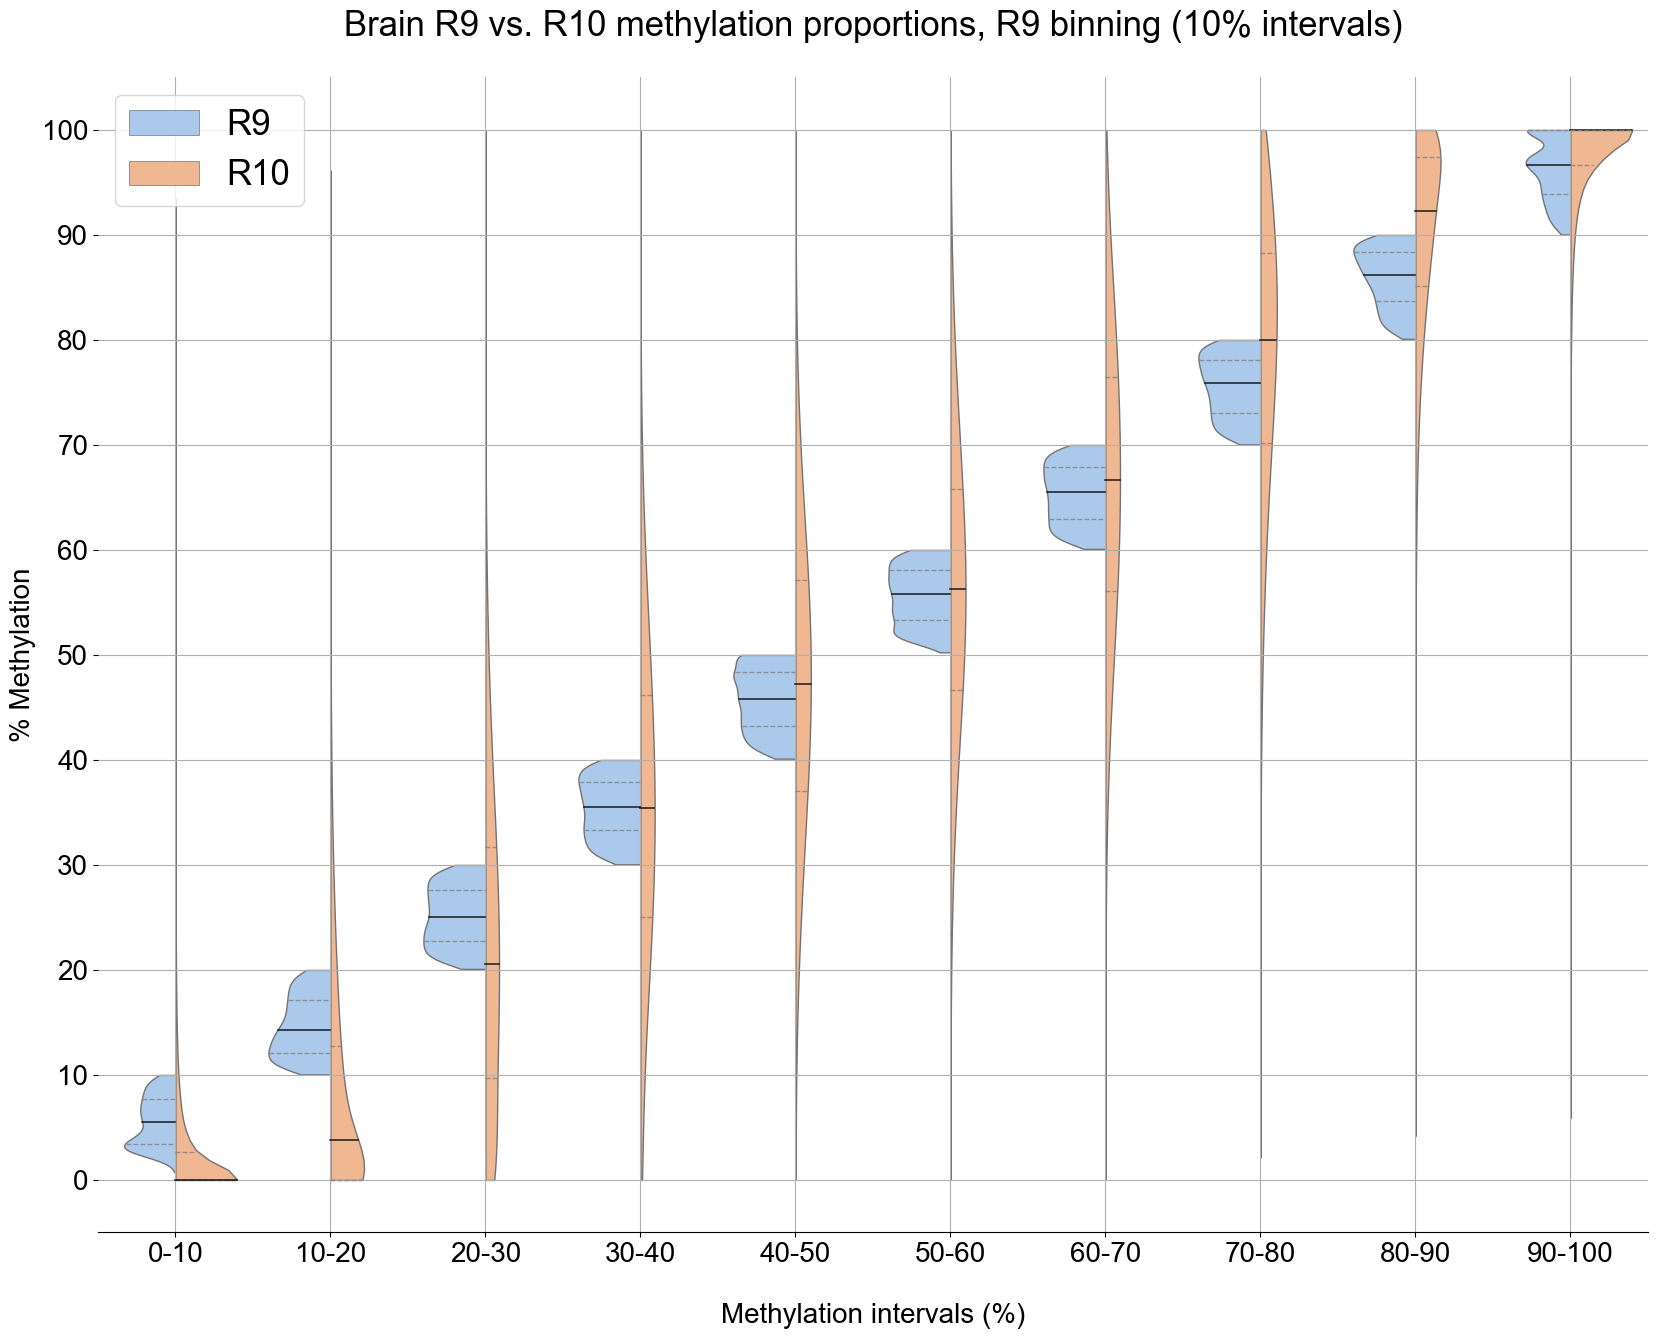

In [16]:
axis = 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

# x axis label
axis_10 = (["0-10", "10-20", "20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100"])

fig, ax = plt.subplots(figsize=(20, 15))

sns.violinplot(data=freqs_100_all, x="int_end", y="freq", hue='R', split='TRUE', cut=0, inner='quartile', linewidth=1, bw=0.3, ax=ax, palette="pastel")

ax.set_yticks(axis)
ax.set_yticklabels(axis, fontsize=20)
ax.set_xticklabels(axis_10, fontsize=20)
ax.set_xlabel("Methylation intervals (%)", fontsize=20, labelpad=25)
ax.set_ylabel("% Methylation", fontsize=20)
plt.grid()
plt.legend(fontsize=25)
plt.title("Brain R9 vs. R10 methylation proportions, R9 binning (10% intervals)", fontsize=25, pad=30)
sns.despine(left=True)
sns.set(style="whitegrid")

#change color, thickness and style of quartile lines
for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(0.95)
    l.set_color('grey')
    l.set_alpha(0.8)
for l in ax.lines[1::3]:
    l.set_linestyle('-')
    l.set_linewidth(1.2)
    l.set_color('black')
    l.set_alpha(0.8)
    
#plt.savefig('/Users/gennerrm/Desktop/figs/NABEC_R9_bin_split_VP.jpg', dpi=300)
#plt.savefig('/Users/gennerrm/Desktop/figs/NABEC_R9_bin_split_VP.pdf', dpi=300)#
#plt.savefig('/Users/gennerrm/Desktop/figs/NABEC_R9_bin_split_VP.svg', dpi=300)

plt.show()


Code for side graph with methylation distribution

/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/gennerrm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

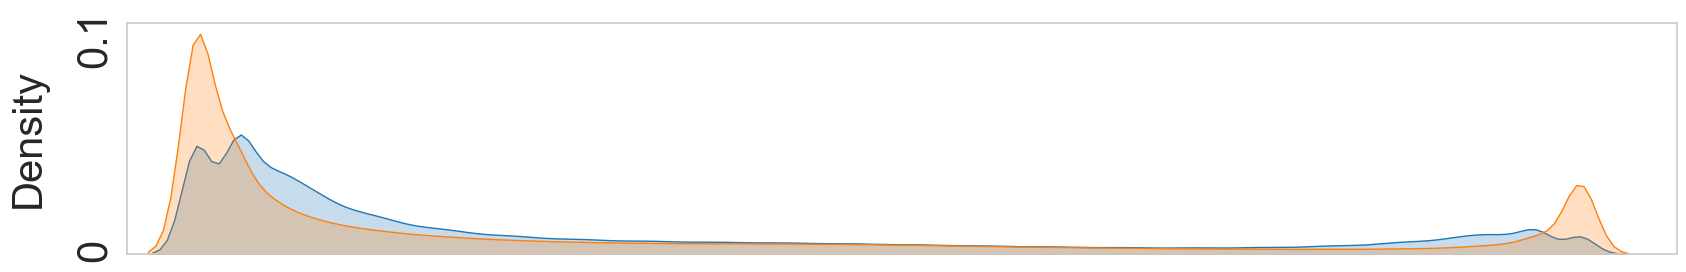

In [17]:
# the graph has to be rotated since it will be added to the side of the violin plot, so axis labels are descending instead of ascending
axis_labels = (['100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0'])

sns.set_palette("pastel")
sns.set_style("whitegrid", {'axes.grid' : False})

fig, ax = plt.subplots(figsize=(20, 3))
sns.kdeplot(inner['freq.R9'], ax=ax, label='R9', color='tab:blue', fill=True)
sns.kdeplot(inner['freq.R10'], ax=ax, label='R10', color='tab:orange', fill=True)

#ax.set_xticks((100, 90, 80, 70, 60, 50, 40, 30, 20, 10, 0))
#ax.set_xticklabels(('100', '90', '80', '70', '60', '50', '40', '30', '20', '10', '0'), fontsize=30)
ax.set_yticks((0.00, 0.10))
ax.set_yticklabels(('0', '0.1'), fontsize=30)


# graph has to be rotated
ax.tick_params(axis='y', labelrotation = 90)

#set x axis limit
ax.set_xlim(105, -7)

plt.xticks(visible=False)
ax.set_ylabel('Density', fontsize=30, labelpad=20)
ax.set_xlabel(None)

#plt.savefig('/Users/gennerrm/Desktop/figs/NABEC_R9_bin_split_VP_cov.jpg', dpi=300)
#plt.savefig('/Users/gennerrm/Desktop/figs/NABEC_R9_bin_split_VP_cov.pdf', dpi=300)
#plt.savefig('/Users/gennerrm/Desktop/figs/NABEC_R9_bin_split_VP_cov.svg', dpi=300)

plt.show()


